In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
plt.style.use('seaborn-notebook')

In [5]:
import sys
# ADAPT FILE PATH TO GET FUNCTIONALITIES
sys.path.append("../../../../inbo-pyutils/gbif/gbif_name_match")
sys.path.append("../../../../inbo-pyutils/gbif/verify_synonyms/")
from gbif_species_name_match import (extract_species_information, 
                                     extract_gbif_species_names_info, 
                                     extract_gbif_accepted_key)
from verify_synonyms import verify_synonym

In [6]:
import asyncio
import aiohttp
import requests

ImportError: No module named 'aiohttp'

# 1. Recorder unique scientific names derived from the nameserver

## Summary

In this section, the output of recorder unique names `recorder_sql_unique_names_output.csv` is matched with GBIF and the resulting matched file (with acceptedKeys for the derived SYNONYMS) is saved in the file `recorder_sql_unique_names_matched.csv`

## Data preparation

I extracted all unique species names from recorder (NBN-data) to make an overview of the species (for all surveys), using the query `recorder_sql_unique_names.sql`. After matching with GBIF, we can make a mapping in between 'recommended names' as defined by recorder and the accepted_keys from GBIF. If we manage to make this mapping, we can later on make an easy selection in both directions GBIF <-> Recorder.

First of all, extract the Recorder unique species names, by querying the NBN-database. for which the Query is stored in `SQL_unique_names.sql`:

In [1]:
recorder_names = pd.read_csv("../data/raw/unique_recommended_names.csv", delimiter='\t', dtype=object)

NameError: name 'pd' is not defined

In [145]:
recorder_names.head()

,RECOMMENDED_TAXON_VERSION_KEY,scientificName,TAXON_GROUP_NAME
0,NHMSYS0000456996,Caylusea,bloemplant
1,NHMSYS0000900079,Listrognathus mactator,insect - vliesvleugelige (Hymenoptera)
2,NBNSYS0100004462,Paratanytarsus dissimilis,insect - vlieg & mug (Diptera)
3,NHMSYS0000603228,Gymnodinium colymbeticum,wier
4,NHMSYS0000875969,Formicinae,insect - vliesvleugelige (Hymenoptera)


In [146]:
len(recorder_names)

144135

In [147]:
recorder_names[recorder_names['TAXON_GROUP_NAME'] == 'niet toegewezen']

,RECOMMENDED_TAXON_VERSION_KEY,scientificName,TAXON_GROUP_NAME
6467,NHMSYS0001697203,Prokaryota,niet toegewezen
10559,NHMSYS0000841310,Arthropoda,niet toegewezen
37772,INBSYS0000012542,Procyon lotor,niet toegewezen
38067,NHMSYS0000841034,Lepidoptera,niet toegewezen
42688,NBNSYS0000160353,Lycopodiopsida,niet toegewezen
65550,NHMSYS0000842161,Protista,niet toegewezen
70145,NBNSYS0000172125,Bryophyta,niet toegewezen
79432,NHMSYS0000841378,Pisces,niet toegewezen
92240,NHMSYS0000841351,Insecta,niet toegewezen
101203,NHMSYS0001747258,Lycopodiophyta,niet toegewezen


In [148]:
recorder_names['TAXON_GROUP_NAME'].unique()

array(['bloemplant', 'insect - vliesvleugelige (Hymenoptera)',
       'insect - vlieg & mug (Diptera)', 'wier', 'diatomee',
       'pseudoschorpioen (Pseudoscorpiones)', 'raderdiertje (Rotifera)',
       'springstaart (Collembola)', 'insect - kever (Coleoptera)',
       'levermos', 'foraminifeer', 'rondworm (Nematoda)', 'zwam',
       'lintworm (Cestoda)', 'ringworm', 'amfibie', 'mollusk (Mollusca)',
       'insect - nachtvlinder', 'bacterie', 'neteldier (=cnidarian)',
       'insect - vlo (Siphonaptera)', 'schaaldier', 'fungoide',
       'insect - trips (Thysanoptera)', 'buikhaarworm (Gastrotricha)',
       'insect - wants, cicade, bladluis (Hemiptera)', 'mijt (Acari)',
       'vogel', 'zuigworm (Trematoda)', 'beenvis (Actinopterygii)',
       'insect - dagvlinder', 'miljoenpoot', 'korstmos', 'spin (Araneae)',
       'mos', 'kraakbeenvis  (Chondrichthyes)', 'platworm (Turbellaria)',
       'varen', 'slurfworm (Kinorhyncha)', 'insect - haft (Ephemeroptera)',
       'ribkwal (Ctenophora

We introduce a mapping in between the INFORMAL GROUP defined by recorder and the kingdom we're dealing with:

In [149]:
mapping_kingdom = {'insect - kever (Coleoptera)' : 'Animalia',
                   'conifeer' : 'Plantae', 
                   'beenvis (Actinopterygii)' : 'Animalia', 
                   'vogel' : 'Animalia', 
                   'insect - nachtvlinder' : 'Animalia', 
                   'bloemplant' : 'Plantae',
                   'spin (Araneae)' : 'Animalia',
                   'insect - vlieg & mug (Diptera)' : 'Animalia', 
                   'diatomee' : 'Plantae',
                   'mollusk (Mollusca)' : 'Animalia',
                   'insect - dagvlinder' : 'Animalia', 
                   'insect - kokerjuffer (Trichoptera)' : 'Animalia',
                   'ringworm' : 'Animalia',
                   'mos' : 'Plantae',
                   'insect - wants, cicade, bladluis (Hemiptera)' : 'Animalia', 
                   'mijt (Acari)' : 'Animalia', 
                   'varen' : 'Plantae', 
                   'schaaldier' : 'Animalia', 
                   'landzoogdier' : 'Animalia', 
                   'kranswier' : 'Plantae',
                   'insect - sprinkhaan & krekel (Orthoptera)' : 'Animalia', 
                   'korstmos' : 'Plantae',
                   'platworm (Turbellaria)' : 'Animalia',
                   'insect - libel (Odonata)' : 'Animalia', 
                   'wier' : 'Plantae', 'paardenstaart' : 'Plantae',
                   'niet toegewezen': None, 
                   'levermos' : 'Plantae', 
                   'tweestaart (Diplura)' : 'Animalia',
                   'rondbek (Agnatha)' : 'Animalia', 
                   'duizendpoot' : 'Animalia', 
                   'wolfsklauw' : 'Plantae', 
                   'amfibie' : 'Animalia', 
                   'bacterie' : 'Bacteria',
                   'insect - nachtvlinder' : 'Animalia',
                   'reptiel' : 'Animalia',
                   'insect - vliesvleugelige (Hymenoptera)' : 'Animalia',
                   'zwam' : 'Fungi',
                   'kraakbeenvis  (Chondrichthyes)' : 'Animalia',
                   'rondworm (Nematoda)' : 'Animalia',
                   'virus' : 'Viruses',
                   'insect - steenvlieg (Plecoptera)' : 'Animalia',
                   'zeezoogdier' : 'Animalia',
                   'ginkgo' : 'Plantae',
                   'parasitaire nematode (Nematoda)' : 'Animalia',
                   'zuigworm (Trematoda)' : 'Animalia',
                   'biesvaren' : 'Plantae',
                   'neteldier (=cnidarian)' : 'Animalia',
                   'insect - trips (Thysanoptera)'  : 'Animalia',
                   'oerdiertje (Protozoa)' : 'Protozoa',
                   'hauwmos' : 'Plantae',
                   'lintworm (Cestoda)' : 'Animalia',
                   'manteldiertje (Urochordata)' : 'Animalia',
                   'stekelhuidige' : 'Animalia',
                   'ectoparasitaire platworm' : 'Animalia',
                   'ribkwal (Ctenophora)' : 'Animalia',
                   'mosdiertje (Bryozoa)' : 'Animalia',
                   'pseudoschorpioen (Pseudoscorpiones)' : 'Animalia',
                   'raderdiertje (Rotifera)' : 'Animalia',
                   'springstaart (Collembola)' : 'Animalia',
                   'foraminifeer' : 'Protozoa',
                   'insect - vlo (Siphonaptera)' : 'Animalia',
                   'fungoide' : 'Fungi', 
                   'buikhaarworm (Gastrotricha)' : 'Animalia',
                   'miljoenpoot' : 'Animalia',
                   'slurfworm (Kinorhyncha)' : 'Animalia',
                   'insect - haft (Ephemeroptera)' : 'Animalia',
                   'slijmzwam' : 'Protozoa',
                   'spons (Porifera)' : 'Animalia',
                   'slurfworm (Echiura)' : 'Animalia',
                   'zeespin (Pycnogonida)' : 'Animalia',
                   'spuitworm (Sipuncula)' : 'Animalia',
                   'insect - gaasvlieg (Neuroptera)' : 'Animalia',
                   'insect - houtluis (Psocoptera)' : 'Animalia',
                   'insect - waaiervleugelige (Strepsiptera)' : 'Animalia',
                   'kelkworm (Entoprocta)' : 'Animalia',
                   'beerdiertje (Tardigrada)' : 'Animalia',
                   'brachiopood (Brachiopoda)' : 'Animalia',
                   'baardworm (Pogonophora)' : 'Animalia',
                   'snoerworm (Nemertinea)' : 'Animalia',
                   'insect - oorworm (Dermaptera)' : 'Animalia',
                   'insect - luis (Phthiraptera)' : 'Animalia',
                   'kaakworm (Gnathostomulida)' : 'Animalia',
                   'pauropood' : 'Animalia',
                   'oerinsect (Protura)' : 'Animalia',
                   'loricifeer' : 'Animalia',
                   'insect - schorpioenvlieg (Mecoptera)' : 'Animalia',
                   'paardenhaarworm (Nematomorpha)' : 'Animalia',
                   'insect - kakkerlak (Dictyoptera)' : 'Animalia',
                   'priapulid' : 'Animalia',
                   'insect - zilvervis (Thysanura)' : 'Animalia',
                   'eikelworm (Hemichordata)' : 'Animalia',
                   'hooiwagen (Opiliones)' : 'Animalia',
                   'middendiertje (Mesozoa)' : 'Animalia',
                   'pijlworm (Chaetognatha)' : 'Animalia',
                   'insect - rotsspringer (Archaeognatha)' : 'Animalia',
                   'dwergpotige (Symphyla)' : 'Animalia',
                   'insect - kameelhalsvlieg (Raphidioptera)' : 'Animalia',
                   'hoefijzerworm (Phoronida)' : 'Animalia',
                   'insect - wandelende tak (Phasmida)' : 'Animalia',
                   'lipklever (Cycliophora)' : 'Animalia',
                   'insect - elzenvlieg (Megaloptera)' : 'Animalia',
                   'schorpioen' : 'Animalia',
                   'insect - bidsprinkhaan (Mantodea)' : 'Animalia',
                   'ongedetermineerd' : None,
                   np.nan : None
                    }

In [150]:
recorder_names['kingdom'] = recorder_names['TAXON_GROUP_NAME'].replace(mapping_kingdom)

In [151]:
recorder_names["kingdom"].unique()

array(['Plantae', 'Animalia', 'Protozoa', 'Fungi', 'Bacteria', None,
       'Viruses'], dtype=object)

In [152]:
len(recorder_names)

144135

In [153]:
recorder_names.head()

,RECOMMENDED_TAXON_VERSION_KEY,scientificName,TAXON_GROUP_NAME,kingdom
0,NHMSYS0000456996,Caylusea,bloemplant,Plantae
1,NHMSYS0000900079,Listrognathus mactator,insect - vliesvleugelige (Hymenoptera),Animalia
2,NBNSYS0100004462,Paratanytarsus dissimilis,insect - vlieg & mug (Diptera),Animalia
3,NHMSYS0000603228,Gymnodinium colymbeticum,wier,Plantae
4,NHMSYS0000875969,Formicinae,insect - vliesvleugelige (Hymenoptera),Animalia


## Asynchronuous performing the requests

As we went to request 144135 different names to the GBIF backbone, a asyncronious requesting should be possible in order to shorten the time to retrieve the results:

### Minimal working example

The concept of an asyncronious request of the API as example:

In [154]:
class Collector():
    def __init__(self):
        self.data = {}

    async def fetch(self, session, name, kingdom, idx):
        parameters = {'verbose': False, 'strict': True, 'name' : name, 'kingdom': kingdom}
        async with client.get('http://api.gbif.org/v1/species/match', params=parameters) as resp:
            if resp.status != 200:
                print(await resp.reason)
            else:
                #print(await resp.json())
                self.data[idx] = await resp.json()

In [155]:
testcase = recorder_names.iloc[:100,:]

In [156]:
names = testcase["scientificName"].values.tolist()
kingdoms = testcase["kingdom"].values.tolist()
inbo_idx = testcase["RECOMMENDED_TAXON_VERSION_KEY"].values.tolist()

In [157]:
test = Collector()
with aiohttp.ClientSession() as client:
    asyncio.get_event_loop().run_until_complete(asyncio.gather(
            *[test.fetch(client, name, kingdom, idx) for name, kingdom, idx in zip(names, kingdoms, inbo_idx)], 
            return_exceptions=True))

In [158]:
len(test.data)

100

Just a single example:

In [159]:
test.data['BMSSYS0000002618']

{'canonicalName': 'Bolbitius conocephalus',
 'class': 'Agaricomycetes',
 'classKey': 186,
 'confidence': 100,
 'family': 'Bolbitiaceae',
 'familyKey': 8440,
 'genus': 'Galerella',
 'genusKey': 8617918,
 'kingdom': 'Fungi',
 'kingdomKey': 5,
 'matchType': 'EXACT',
 'order': 'Agaricales',
 'orderKey': 1499,
 'phylum': 'Basidiomycota',
 'phylumKey': 34,
 'rank': 'SPECIES',
 'scientificName': 'Bolbitius conocephalus (Bull.) Fr., 1874',
 'species': 'Galerella conocephala',
 'speciesKey': 5449507,
 'status': 'SYNONYM',
 'synonym': True,
 'usageKey': 2529985}

### Chunked version execution

Let's try it in chunks of around 100 requests in batches of 50000:

In [160]:
len(recorder_names)

144135

In [161]:
import time

I made the following cells in raw-text to exclude them from running the whole sequence again when just running the notebook, the result of the sequence of runs is loaded as a variable: `recorder_matched` in the next code cell

Not missing that much requests anymore, since we're less than 144135 requests

### Retrying the missing requests 

Some requests just went wrong, let's redo this set of around 100 failures..

Reading in the matches names from the last performed matching

### getting the acceptedKey when the status is not accepted but SYNONYM

## Checking the matched result

In [162]:
recorder_matched = pd.read_csv("../data/interim/recorder_sql_unique_names_matched.csv", dtype=object)

In [163]:
recorder_matched = recorder_matched.rename(columns={"Unnamed: 0.1": "INBO_identifier"})

In [164]:
recorder_matched.head()

,INBO_identifier,canonicalName,class,classKey,confidence,family,familyKey,genus,genusKey,kingdom,...,phylumKey,rank,scientificName,species,speciesKey,status,synonym,usageKey,acceptedKey,acceptedScientificName
0,INBSYS0000005533,Cotoneaster villosulus,Magnoliopsida,220,100,Rosaceae,5015,Cotoneaster,3025563,Plantae,...,7707728,SPECIES,Cotoneaster villosulus (Rehder & E.H. Wilson) ...,Cotoneaster acutifolius,3025770,SYNONYM,True,3025564,3025565,Cotoneaster acutifolius var. villosulus Rehd. ...
1,NBNSYS0000019326,NaN,NaN,NaN,100,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN
2,NBNSYS0000022430,Leuctra hippopus,Insecta,216,100,Leuctridae,2998,Leuctra,2001760,Animalia,...,54,SPECIES,"Leuctra hippopus Kempny, 1899",Leuctra hippopus,2001976,ACCEPTED,False,2001976,2001976,"Leuctra hippopus Kempny, 1899"
3,NBNSYS0200001885,Axonopus compressus,Liliopsida,196,100,Poaceae,3073,Mesosetum,4113460,Plantae,...,7707728,SPECIES,Axonopus compressus (Sw.) P.Beauv.,Mesosetum compressum,4114391,SYNONYM,True,2705924,4114391,Mesosetum compressum Swallen
4,NHMSYS0001480349,Dasyscyphus relicinus,Leotiomycetes,179,100,Lachnaceae,3295205,Lachnum,2581043,Fungi,...,95,SPECIES,Dasyscyphus relicinus (Fr.) Boud.,Lachnum relicinum,3489190,SYNONYM,True,3281874,3489190,"Lachnum relicinum (Fr.) P. Karst., 1871"


Some summary information:

In [165]:
recorder_matched.columns

Index(['INBO_identifier', 'canonicalName', 'class', 'classKey', 'confidence',
       'family', 'familyKey', 'genus', 'genusKey', 'kingdom', 'kingdomKey',
       'matchType', 'note', 'order', 'orderKey', 'phylum', 'phylumKey', 'rank',
       'scientificName', 'species', 'speciesKey', 'status', 'synonym',
       'usageKey', 'acceptedKey', 'acceptedScientificName'],
      dtype='object')

In [166]:
recorder_matched["matchType"].count()

144135

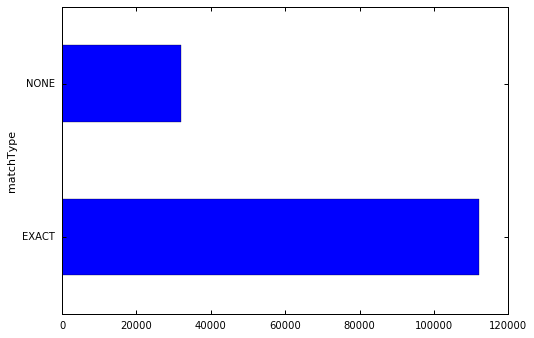

In [167]:
recorder_matched.groupby(("matchType")).count()["confidence"].plot(kind="barh")

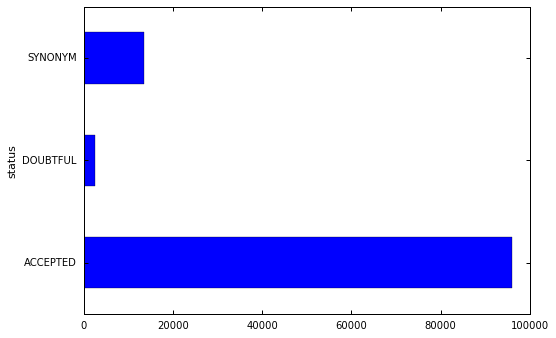

In [168]:
recorder_matched.groupby(("status")).count()["canonicalName"].plot(kind="barh")

Other 39000 are NONE...

#### Different reasons for failed answer in the note:

*Multiple equal matches for...* added by the name

In [169]:
sum(recorder_matched["note"].str.contains("too little").dropna())

19818

*No match because of too little confidence*

In [170]:
sum(recorder_matched["note"].str.contains("Multiple equal matches").dropna())

988

*N synonym homonyms* (with N = 2, 3,...) -> When SYNONYM is found

In [171]:
sum(recorder_matched["note"].str.contains("synonym homonyms").dropna())

1344

In [172]:
recorder_matched.columns

Index(['INBO_identifier', 'canonicalName', 'class', 'classKey', 'confidence',
       'family', 'familyKey', 'genus', 'genusKey', 'kingdom', 'kingdomKey',
       'matchType', 'note', 'order', 'orderKey', 'phylum', 'phylumKey', 'rank',
       'scientificName', 'species', 'speciesKey', 'status', 'synonym',
       'usageKey', 'acceptedKey', 'acceptedScientificName'],
      dtype='object')

In [173]:
recorder_matched.head()

,INBO_identifier,canonicalName,class,classKey,confidence,family,familyKey,genus,genusKey,kingdom,...,phylumKey,rank,scientificName,species,speciesKey,status,synonym,usageKey,acceptedKey,acceptedScientificName
0,INBSYS0000005533,Cotoneaster villosulus,Magnoliopsida,220,100,Rosaceae,5015,Cotoneaster,3025563,Plantae,...,7707728,SPECIES,Cotoneaster villosulus (Rehder & E.H. Wilson) ...,Cotoneaster acutifolius,3025770,SYNONYM,True,3025564,3025565,Cotoneaster acutifolius var. villosulus Rehd. ...
1,NBNSYS0000019326,NaN,NaN,NaN,100,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN
2,NBNSYS0000022430,Leuctra hippopus,Insecta,216,100,Leuctridae,2998,Leuctra,2001760,Animalia,...,54,SPECIES,"Leuctra hippopus Kempny, 1899",Leuctra hippopus,2001976,ACCEPTED,False,2001976,2001976,"Leuctra hippopus Kempny, 1899"
3,NBNSYS0200001885,Axonopus compressus,Liliopsida,196,100,Poaceae,3073,Mesosetum,4113460,Plantae,...,7707728,SPECIES,Axonopus compressus (Sw.) P.Beauv.,Mesosetum compressum,4114391,SYNONYM,True,2705924,4114391,Mesosetum compressum Swallen
4,NHMSYS0001480349,Dasyscyphus relicinus,Leotiomycetes,179,100,Lachnaceae,3295205,Lachnum,2581043,Fungi,...,95,SPECIES,Dasyscyphus relicinus (Fr.) Boud.,Lachnum relicinum,3489190,SYNONYM,True,3281874,3489190,"Lachnum relicinum (Fr.) P. Karst., 1871"


# 2. Verify the SYNONYM with a list of known verifications

The workflow is comparable to the one described on [https://github.com/inbo/invasive-t0-occurrences/issues/52](https://github.com/inbo/invasive-t0-occurrences/issues/52), in order to derive an overview of the verified matching of the nameserver towards the GBIF services

In [174]:
recorder_matched["nameMatchValidation"] = np.nan

In [176]:
recorder_matched.loc[recorder_matched["status"] == "ACCEPTED", "nameMatchValidation"] = 'ok'
recorder_matched.loc[recorder_matched["status"] == "DOUBTFUL", "nameMatchValidation"] = 'ok: DOUBTFUL'

Running the verification of the synonyms

In [177]:
recorder_matched.columns

Index(['INBO_identifier', 'canonicalName', 'class', 'classKey', 'confidence',
       'family', 'familyKey', 'genus', 'genusKey', 'kingdom', 'kingdomKey',
       'matchType', 'note', 'order', 'orderKey', 'phylum', 'phylumKey', 'rank',
       'scientificName', 'species', 'speciesKey', 'status', 'synonym',
       'usageKey', 'acceptedKey', 'acceptedScientificName',
       'nameMatchValidation'],
      dtype='object')

In [178]:
recorder_matched = recorder_matched.rename(columns={"status": "gbif_status"})

In [179]:
recorder_matched = verify_synonym(recorder_matched, "temp_out.tsv", 
                                  "https://raw.githubusercontent.com/inbo/alien-species-checklist/master/data/vocabularies/verified-synonyms.tsv", 
                                  usagekeycol='usageKey', 
                                  acceptedkeycol='acceptedKey', 
                                  taxonomicstatuscol='gbif_status', 
                                  outputcol='nameMatchValidation')

Number of corrections initiated by the synonym verification:

In [180]:
temp = recorder_matched[(recorder_matched["nameMatchValidation"].notnull()) & 
                 (recorder_matched["nameMatchValidation"].str.contains("ok:"))
                ]
len(temp[~temp["nameMatchValidation"].str.contains("ok: DOUBTFUL")])


120

remove redundant columns:

In [185]:
recorder_matched = recorder_matched.drop(["gbifapi_usageKey", "gbifapi_acceptedKey"], axis=1)

# 3. Data product

For the final data product, we want to provide the matches we can trust, i.e. the status is `ACCEPTED`, `DOUBTFUL` or a verified `SYNONYM`

In [186]:
recorder_matched_verified = recorder_matched[recorder_matched['nameMatchValidation'].notnull & recorder_matched['nameMatchValidation'].str.contains('^ok', regex=True)]

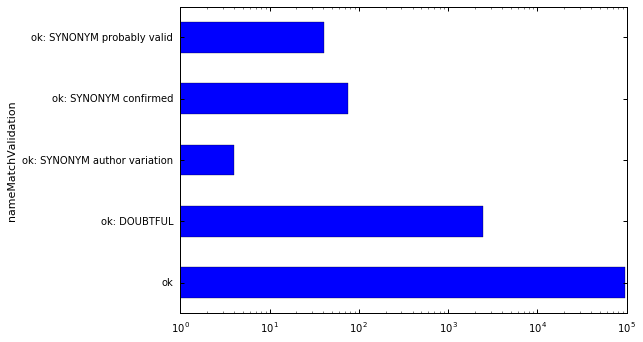

In [187]:
recorder_matched_verified.groupby(('nameMatchValidation')).count()['INBO_identifier'].plot(kind="barh", logx=True)

In [189]:
recorder_matched_verified.to_csv('../data/processed/recorder_sql_unique_names_matched_verified.tsv',
                                 index=False, sep='\t', na_rep="")